# Movie recommender system with SVD

The goal of this project is to create a Movie recommender system using SVD decomposition. The principle will be the following : we'll transform the dataset in an item-user matrix, which of course will be full of missing-values, the goal is to apply the SVD decomposition on this matrix after removing a testing part of the data to check our model performances. If we use a full svd, the original matrix will be exactly equal to the product of the decomposed matrixes, and therefore, any prediction would be exactly the original data which is the litteral definition of overfitting, but if we truncate the svd, we'll obtain a decomposition that is focusing on the latent factors that are picking the most variance and therefore that are explaining those latent factors. We are litterlay forcing mathematically the model to find hidden relations that are representing most of the information diversity, we're taking all the noise off therefore creating the pertinence of the prediction. In any case, U and V matrixes that we'll respectively represent latent factors about the users and the movies will be determined by the original item-user matrix, making the imputing of missing values absolutely essential, we'll explore different imputing methods and then we'll keep the best. We'll also try different values of k (number of singular values that we keep). To check the model perfomances, we will reconstruct the item user matrix with the truncated svd decomposition and the calculate the MAE on the data that we were keeping for the test. Finally, we'll create the recommender system taking in input a user and a movie and making a prediction ! 

### 0 : Imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

### 1: Data Import & Exploration

In [2]:
file_path = r'ml-100k/u.data'
df = pd.read_csv(file_path, sep='\t', header=None, names=['UserID', 'ItemID', 'Rating', 'Timestamp'])


In [3]:
df.drop(['Timestamp'],inplace=True,axis=1)

In [4]:
df.info() #No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   UserID  100000 non-null  int64
 1   ItemID  100000 non-null  int64
 2   Rating  100000 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


In [5]:
df

,UserID,ItemID,Rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [6]:
print(df.nunique())

UserID     943
ItemID    1682
Rating       5
dtype: int64


### 2 : Split the data

In [7]:
from sklearn.model_selection import train_test_split

train_data,test_data=train_test_split(df,test_size=0.25)

### 3 : User Matrix

We construct the user-item matrix and imput the missing values only based on the training set to avoid overfitting 

In [8]:
user_item_matrix = df.pivot(index='UserID', columns='ItemID', values='Rating')

In [9]:
user_item_matrix

ItemID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
user_item_matrix.isnull().sum().sum() #we have exactly 100k non-nan values on the 1 586 126 combinaisons possible

1486126

In [11]:
user_item_matrix.shape[0]*user_item_matrix.shape[1]-user_item_matrix.isnull().sum().sum()

100000

In [12]:
user_item_train = user_item_matrix.copy()
for (user, item) in test_data[['UserID', 'ItemID']].values:
    user_item_train.loc[user, item] = np.nan 

In [13]:
user_item_train.isnull().sum().sum() #Exactly 75k non nan values now that we have removed the test values

1511126

In [14]:
user_item_train.shape[0]*user_item_train.shape[1]-user_item_train.isnull().sum().sum()

75000

### 4 : Imputing of the missing values
1) First approach by 0

In [15]:
user_item_train_0=user_item_train.fillna(0)

2. By mean by user

In [16]:
user_item_train_mean = user_item_train.apply(lambda row: row.fillna(row.mean()), axis=1)

3. KNN

In [17]:
from sklearn.impute import KNNImputer

def knn_impute_handle_missing_columns(user_item_matrix, n_neighbors=5):
    fully_nan_columns = user_item_matrix.columns[user_item_matrix.isna().all()]
    partial_matrix = user_item_matrix.drop(columns=fully_nan_columns)
    imputer = KNNImputer(n_neighbors=n_neighbors)
    partial_imputed_array = imputer.fit_transform(partial_matrix)
    partial_imputed_df = pd.DataFrame(partial_imputed_array, index=partial_matrix.index, columns=partial_matrix.columns)
    for col in fully_nan_columns:
        partial_imputed_df[col] = 0 
    full_imputed_df = partial_imputed_df.reindex(columns=user_item_matrix.columns)
    return full_imputed_df


In [18]:
user_item_train_KNN=knn_impute_handle_missing_columns(user_item_train)

4. SuperCharged KNN

We propose ourselves to try a last imputing approach using the other data of the dataset, we'll try to create a better KNN imputing by adding features about the users and the genre they most like. Let's explore the data first !

movie data: ItemID / Liste of movie type

In [19]:
data=df.copy()

In [20]:
column_names = ['ItemID', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 
                'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 
                'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 
                'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
file_path = 'ml-100k/u.item'
items = pd.read_csv(file_path, sep='|', names=column_names, encoding='latin-1', index_col= 'ItemID')
items.drop(columns=['movie_title', 'release_date', 'video_release_date', 'IMDb_URL'], inplace=True)

items.head()

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


We only keep the Movie ID (=ItemID) and the genre of each movie

In [21]:
items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1682 entries, 1 to 1682
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   unknown      1682 non-null   int64
 1   Action       1682 non-null   int64
 2   Adventure    1682 non-null   int64
 3   Animation    1682 non-null   int64
 4   Children's   1682 non-null   int64
 5   Comedy       1682 non-null   int64
 6   Crime        1682 non-null   int64
 7   Documentary  1682 non-null   int64
 8   Drama        1682 non-null   int64
 9   Fantasy      1682 non-null   int64
 10  Film-Noir    1682 non-null   int64
 11  Horror       1682 non-null   int64
 12  Musical      1682 non-null   int64
 13  Mystery      1682 non-null   int64
 14  Romance      1682 non-null   int64
 15  Sci-Fi       1682 non-null   int64
 16  Thriller     1682 non-null   int64
 17  War          1682 non-null   int64
 18  Western      1682 non-null   int64
dtypes: int64(19)
memory usage: 262.8 KB


users data: UserID / Age / Gender / Occupation

In [22]:
column_names = ['UserID', 'Age', 'Gender', 'Occupation', 'ZIP_code']
file_path = 'ml-100k/u.user'
users = pd.read_csv(file_path, sep='|', names=column_names, encoding='latin-1', index_col='UserID')
users.drop(columns='ZIP_code', inplace=True)

users.head()

,Age,Gender,Occupation
UserID,,,
1,24,M,technician
2,53,F,other
3,23,M,writer
4,24,M,technician
5,33,F,other


We only keep data that might be usefull to create clusters

# Trying to mix data

In [23]:
movie_genre = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 
                'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 
                'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

df = users.copy()

df[movie_genre] = 0
df.head()

,Age,Gender,Occupation,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
UserID,,,,,,,,,,,,,,,,,,,,,
1,24,M,technician,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,53,F,other,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,M,writer,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,24,M,technician,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,33,F,other,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Creating the data frame with the age, gender, occupation and each type of movie the user watched/liked (initialised at 0)

In [24]:

def genre_attributor_optimized(data, items, df):
    data_with_genres = pd.merge(data, items, left_on="ItemID", right_index=True, how="left")
    data_with_genres["transformed_rating"] = (data_with_genres["Rating"] - 1) ** 2
    for user_id in tqdm(data_with_genres["UserID"].unique(), desc="Processing users"):
        user_data = data_with_genres[data_with_genres["UserID"] == user_id]
        genre_columns = items.columns
        genre_scores = user_data[genre_columns].multiply(user_data["transformed_rating"], axis=0).sum()
        df.loc[user_id, genre_columns] += genre_scores

    return df


This function fills the movie genres watched by users in the DataFrame defined above, based on the genre associated with each movie and whether they liked it or not using this function: (x-1)**2.

1 star --> 0  
2 stars --> 1  
3 stars --> 4  
4 stars --> 9  
5 stars --> 16

In [25]:
genre_attributor_optimized(data, items, df)

Processing users: 100%|██████████| 943/943 [00:05<00:00, 164.36it/s]


,Age,Gender,Occupation,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
UserID,,,,,,,,,,,,,,,,,,,,,
1,24,M,technician,9,533,243,84,80,719,191,...,13,16,94,71,45,433,439,416,207,46
2,53,F,other,0,92,34,9,22,141,83,...,4,25,8,4,28,164,33,95,26,0
3,23,M,writer,0,61,26,0,0,53,56,...,0,5,13,2,62,34,32,78,23,0
4,24,M,technician,0,75,30,0,0,64,57,...,0,0,9,16,49,36,55,104,25,0
5,33,F,other,9,336,216,121,96,500,82,...,9,16,121,78,14,77,259,99,97,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,26,F,student,0,191,77,9,9,193,36,...,9,0,4,9,9,146,87,125,48,0
940,32,M,administrator,0,164,64,25,54,304,79,...,0,27,18,43,34,175,111,141,86,0
941,20,M,student,0,90,68,41,25,72,4,...,0,0,0,9,16,16,77,71,16,0


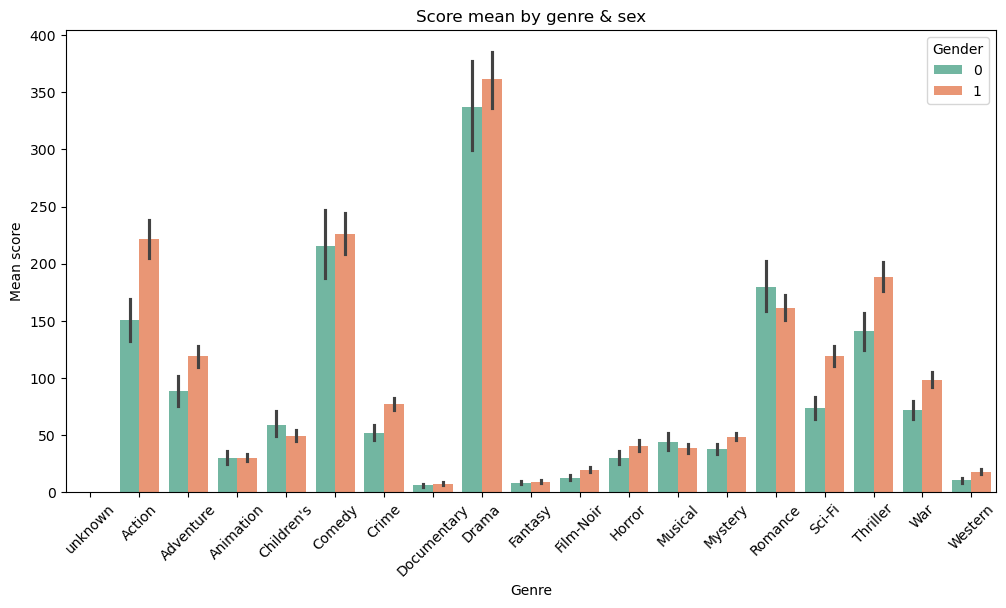

In [130]:
genres_columns = df.loc[:, 'unknown':'Western'].columns
df_melted = df.melt(id_vars=['Gender'], value_vars=genres_columns, var_name='Genre', value_name='Score')
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Genre', y='Score', hue='Gender', estimator='mean', palette='Set2')

plt.title('Score mean by genre & sex')
plt.xlabel('Genre')
plt.ylabel('Mean score')
plt.xticks(rotation=45)

plt.show()

Men tend to rate action, adventure, comedy, drama, and thriller movies more highly than women.

Women tend to rate romance movies more highly than men.

In general, men tend to give higher ratings overall.

In [27]:
users.describe()

,Age
count,943.000000
mean,34.051962
std,12.192740
min,7.000000
25%,25.000000
50%,31.000000
75%,43.000000
max,73.000000


In [30]:
df.drop('Age_list', axis=1, inplace=True)

In [39]:
df['Age_list'] = df['Age'].astype(str).str.slice(0,1)

In [42]:
df.drop('Age', axis=1, inplace=True)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'unknown'),
  Text(1, 0, 'Action'),
  Text(2, 0, 'Adventure'),
  Text(3, 0, 'Animation'),
  Text(4, 0, "Children's"),
  Text(5, 0, 'Comedy'),
  Text(6, 0, 'Crime'),
  Text(7, 0, 'Documentary'),
  Text(8, 0, 'Drama'),
  Text(9, 0, 'Fantasy'),
  Text(10, 0, 'Film-Noir'),
  Text(11, 0, 'Horror'),
  Text(12, 0, 'Musical'),
  Text(13, 0, 'Mystery'),
  Text(14, 0, 'Romance'),
  Text(15, 0, 'Sci-Fi'),
  Text(16, 0, 'Thriller'),
  Text(17, 0, 'War'),
  Text(18, 0, 'Western')])

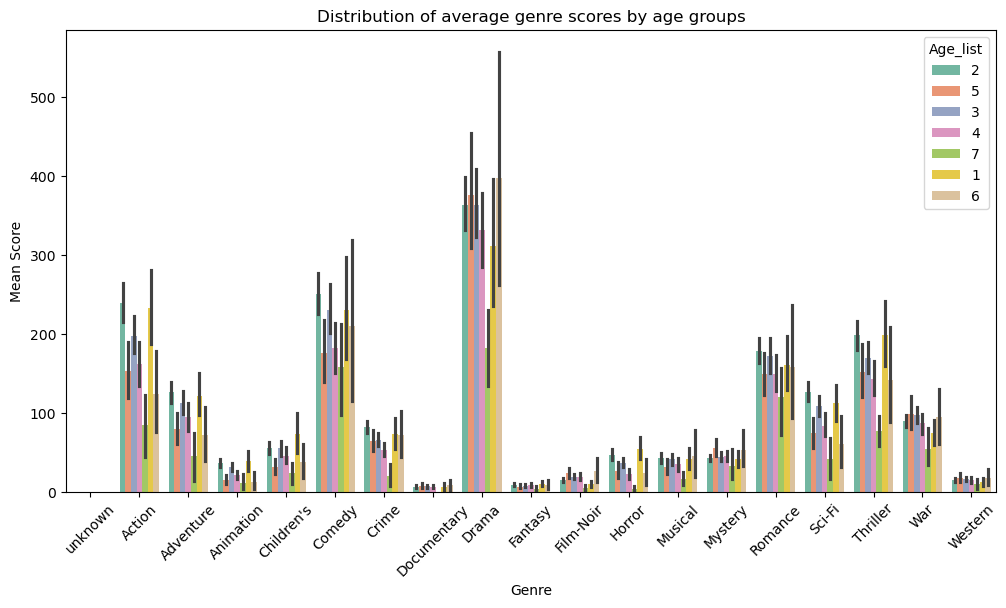

In [131]:
genres_columns = df.loc[:, 'unknown':'Western'].columns
df_melted = df.melt(id_vars=['Age_list'], value_vars=genres_columns, var_name='Genre', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Genre', y='Score', hue='Age_list', estimator='mean', palette='Set2')

plt.title("Distribution of average genre scores by age groups")
plt.xlabel('Genre')
plt.ylabel('Mean Score')
plt.xticks(rotation=45)

Children tend to like action, adventure, comedy, crime, drama, horror, and thriller movies.

Children tend to perhaps overrate movies in general.

##### Now that the exploration is over, we have a dataset that gives more information about every users. Let's use it for our KNN.

In [43]:
df.tail()

,Gender,Occupation,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Age_list
UserID,,,,,,,,,,,,,,,,,,,,,
939,F,student,0,191,77,9,9,193,36,0,...,0,4,9,9,146,87,125,48,0,2
940,M,administrator,0,164,64,25,54,304,79,0,...,27,18,43,34,175,111,141,86,0,3
941,M,student,0,90,68,41,25,72,4,0,...,0,0,9,16,16,77,71,16,0,2
942,F,librarian,0,188,155,57,149,224,0,0,...,16,22,61,87,206,65,196,139,41,4
943,M,student,0,497,237,13,40,312,208,0,...,0,115,37,22,210,120,307,120,36,2


In [36]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [44]:
label_encoders = {}
for column in ['Gender', 'Occupation']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [48]:
scaler = StandardScaler()
user_df_scaled = pd.DataFrame(scaler.fit_transform(df))

In [63]:
user_df_scaled.index = pd.RangeIndex(start=1, stop=len(user_df_scaled) + 1, name='UserID')

In [64]:
user_df_scaled

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.638328,1.227058,10.983437,1.630242,1.123663,1.233139,0.368461,2.085782,1.747321,4.712713,...,-0.057597,1.037395,0.562471,-0.007461,1.722458,3.111897,1.510024,1.391990,1.250788,-0.769612
2,-1.566593,0.325526,-0.083455,-0.536988,-0.641460,-0.478848,-0.399930,-0.343025,0.190852,-0.488885,...,0.288350,-0.542405,-0.651904,-0.390798,-0.017082,-0.680521,-0.496397,-0.773422,-0.639359,1.607279
3,0.638328,1.377313,-0.083455,-0.689333,-0.709024,-0.684286,-0.691389,-0.712809,-0.198265,0.651191,...,-0.480421,-0.450556,-0.688154,0.375876,-0.857752,-0.689862,-0.602656,-0.809313,-0.639359,-0.769612
4,0.638328,1.227058,-0.083455,-0.620532,-0.675242,-0.684286,-0.691389,-0.666586,-0.183853,0.651191,...,-0.672614,-0.524035,-0.434404,0.082736,-0.844819,-0.475021,-0.440142,-0.785386,-0.639359,-0.769612
5,-1.566593,0.325526,10.983437,0.662114,0.895633,2.077719,0.580430,1.165525,0.176441,-0.488885,...,-0.057597,1.533378,0.689346,-0.706487,-0.579684,1.430530,-0.471395,0.075994,-0.269548,0.022685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,-1.566593,1.076802,-0.083455,-0.050467,-0.278301,-0.478848,-0.572156,-0.124516,-0.486500,-0.488885,...,-0.672614,-0.615884,-0.561279,-0.819233,-0.133483,-0.176111,-0.308881,-0.510223,-0.639359,-0.769612
940,0.638328,-1.627791,-0.083455,-0.183155,-0.388093,-0.113624,0.024010,0.341915,0.133205,-0.488885,...,0.365228,-0.358707,0.054971,-0.255502,0.054051,0.048072,-0.208872,-0.055606,-0.639359,0.022685
941,0.638328,1.076802,-0.083455,-0.546817,-0.354311,0.251600,-0.360186,-0.632969,-0.947675,-0.488885,...,-0.672614,-0.689363,-0.561279,-0.661388,-0.974153,-0.269520,-0.646410,-0.893059,-0.639359,-0.769612


In [62]:
user_item_train.index.name

'UserID'

In [65]:
combined_data = pd.concat([user_item_train, user_df_scaled], axis=1)

In [66]:
combined_data

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,NaN,3.0,5.0,NaN,1.0,5.0,3.0,...,-0.057597,1.037395,0.562471,-0.007461,1.722458,3.111897,1.510024,1.391990,1.250788,-0.769612
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,0.288350,-0.542405,-0.651904,-0.390798,-0.017082,-0.680521,-0.496397,-0.773422,-0.639359,1.607279
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.480421,-0.450556,-0.688154,0.375876,-0.857752,-0.689862,-0.602656,-0.809313,-0.639359,-0.769612
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.672614,-0.524035,-0.434404,0.082736,-0.844819,-0.475021,-0.440142,-0.785386,-0.639359,-0.769612
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.057597,1.533378,0.689346,-0.706487,-0.579684,1.430530,-0.471395,0.075994,-0.269548,0.022685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,-0.672614,-0.615884,-0.561279,-0.819233,-0.133483,-0.176111,-0.308881,-0.510223,-0.639359,-0.769612
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,NaN,NaN,NaN,...,0.365228,-0.358707,0.054971,-0.255502,0.054051,0.048072,-0.208872,-0.055606,-0.639359,0.022685
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,-0.672614,-0.689363,-0.561279,-0.661388,-0.974153,-0.269520,-0.646410,-0.893059,-0.639359,-0.769612


In [115]:
def knn_impute_based_on_user_features(user_item_matrix, user_features, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors, metric='nan_euclidean')
    user_features_imputed = imputer.fit_transform(user_features)
    user_features_imputed_df = pd.DataFrame(user_features_imputed, 
                                            index=user_features.index, 
                                            columns=user_features.columns)
    for user in tqdm(user_item_matrix.index, desc="Processing users"):
        for item in tqdm(user_item_matrix.columns, desc=f"Processing items for user {user}", leave=False):
            if pd.isna(user_item_matrix.loc[user, item]):
                similar_users = user_features_imputed_df.loc[user].values
                item_ratings = user_item_matrix.loc[:, item]  
                non_nan_ratings = item_ratings[~item_ratings.isna()]
                
                if len(non_nan_ratings) > 0:
                    user_item_matrix.loc[user, item] = non_nan_ratings.mean()

    return user_item_matrix

In [116]:
user_item_train_KNN_supercharged = knn_impute_based_on_user_features(user_item_train, user_df_scaled, n_neighbors=5)

Processing users: 100%|██████████| 943/943 [10:32<00:00,  1.49it/s]


In [118]:
user_item_train_KNN_supercharged = user_item_train.apply(lambda row: row.fillna(row.mean()), axis=1)

In [119]:
user_item_train_KNN_supercharged

ItemID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.000000,3.000000,4.000000,3.518987,3.000000,5.000000,3.813149,1.000000,5.000000,3.000000,...,3.0,4.0,3.0,2.0,3.110914,1.0,3.110914,2.0,3.0,3.110914
2,4.000000,3.244898,3.056338,3.518987,3.333333,3.722222,3.813149,3.960227,3.910314,2.000000,...,3.0,4.0,3.0,2.0,3.097332,1.0,3.097332,2.0,3.0,3.097332
3,3.892537,3.244898,3.056338,3.518987,3.333333,3.722222,3.813149,3.960227,3.910314,3.808824,...,3.0,4.0,3.0,2.0,3.082698,1.0,3.082698,2.0,3.0,3.082698
4,3.892537,3.244898,3.056338,3.518987,3.333333,3.722222,3.813149,3.960227,3.910314,3.808824,...,3.0,4.0,3.0,2.0,3.102927,1.0,3.102927,2.0,3.0,3.102927
5,4.000000,3.000000,3.056338,3.518987,3.333333,3.722222,3.813149,3.960227,3.910314,3.808824,...,3.0,4.0,3.0,2.0,3.065524,1.0,3.065524,2.0,3.0,3.065524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,3.892537,3.244898,3.056338,3.518987,3.333333,3.722222,3.813149,3.960227,5.000000,3.808824,...,3.0,4.0,3.0,2.0,3.117852,1.0,3.117852,2.0,3.0,3.117852
940,3.892537,3.244898,3.056338,2.000000,3.333333,3.722222,4.000000,3.960227,3.910314,3.808824,...,3.0,4.0,3.0,2.0,3.078734,1.0,3.078734,2.0,3.0,3.078734
941,5.000000,3.244898,3.056338,3.518987,3.333333,3.722222,4.000000,3.960227,3.910314,3.808824,...,3.0,4.0,3.0,2.0,3.096308,1.0,3.096308,2.0,3.0,3.096308


##### We constat that some columns are still empty, we'll a add a step of filling with the mean by user

### 5 : Apply SVD decomposition


In [120]:
from numpy.linalg import svd

def svd_for_prediction(item_user_matrix:pd.DataFrame):
    U_, S_, V_ = np.linalg.svd(item_user_matrix)
    Sigma_ = np.zeros((user_item_train.shape[0], user_item_train.shape[1]))  # Create Sigma matrix with the shape of A
    np.fill_diagonal(Sigma_, S_)  # Place singular values on the diagonal
    # print(U_@Sigma_@V_)
    return U_,Sigma_,V_

In [121]:
U_, Sigma_,V_=svd_for_prediction(user_item_train_0)

In [122]:
np.isclose(user_item_train_0,U_@Sigma_@V_) #The SVD decomposition is functional !

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [123]:
def truncatesvd(U, Sigma, V, k=None): #Method that returns the truncated matrix for svd
    if k is None:
        return U, Sigma, V
    U_r = U[:, :k]          
    Sigma_r = Sigma[:k, :k]  
    V_r = V[:k, :]           
    
    return U_r, Sigma_r, V_r

In [124]:
def predictionmatrix(initialmatrix,k=None):
    U_,Sigma_,V_=svd_for_prediction(initialmatrix)
    U_r,Sigma_r,V_r=truncatesvd(U_,Sigma_,V_,k)
    reconstructed_matrix = np.dot(np.dot(U_r, Sigma_r), V_r)
    tolerance = 1e-10
    reconstructed_matrix = np.where(np.abs(reconstructed_matrix) < tolerance, 0, reconstructed_matrix)
    return reconstructed_matrix
#Method that returns the reconstructed matrix given an entry matrix and a k

### 6 : Evaluation

In [125]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def evaluate_reconstructed_matrix(reconstructed_matrix, test_data, user_item_train):
    y_pred = []
    y_true = []
    for index, row in test_data.iterrows():
        user_id = row['UserID']
        item_id = row['ItemID']
        true_rating = row['Rating']
        user_index = user_item_train.index.get_loc(user_id) 
        item_index = user_item_train.columns.get_loc(item_id)
        predicted_rating = reconstructed_matrix[user_index, item_index]
        y_pred.append(predicted_rating)
        y_true.append(true_rating)
    mse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true,y_pred)
    return mse,mae

In [126]:
print(evaluate_reconstructed_matrix(predictionmatrix(user_item_train_mean),test_data,user_item_train))

(1.0432423400997697, 0.8355938852918473)


In [134]:
def test_svd_performance(matrix_to_test: list, test_data, user_item_train, max_k=50):
    # Initialiser un dictionnaire pour stocker les résultats
    results = {matrix_name: {'mse': [], 'mae': []} for matrix_name in matrix_to_test}

    # Tester chaque k pour chaque matrice
    for matrix_name in matrix_to_test:
        matrix = matrix_to_test[matrix_name]
        for k in tqdm(range(1, max_k+1), desc=f"Testing k for {matrix_name}"):
            # Calculer les prédictions avec la matrice actuelle
            predicted_matrix = predictionmatrix(matrix, k=k)

            # Calculer MSE et MAE
            mse = evaluate_reconstructed_matrix(predicted_matrix, test_data, user_item_train)[0]
            mae = evaluate_reconstructed_matrix(predicted_matrix, test_data, user_item_train)[1]

            # Stocker les résultats pour chaque k
            results[matrix_name]['mse'].append((k, mse))
            results[matrix_name]['mae'].append((k, mae))
    
    return results
matrix_to_test = {
    'mean_imputation': user_item_train_mean,
    'zero_imputation': user_item_train_0,
    'knn_imputation': user_item_train_KNN,
    'KNN_supercharged':user_item_train_KNN_supercharged
}
results = test_svd_performance(matrix_to_test, test_data, user_item_train, max_k=20)

Testing k for KNN_supercharged: 100%|██████████| 20/20 [00:45<00:00,  2.26s/it]


In [136]:
def plot_best_model_performance(results):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot for MSE
    for matrix_name in results:
        mse_values = results[matrix_name]['mse']
        k_values, mse_scores = zip(*mse_values)
        ax[0].plot(k_values, mse_scores, label=matrix_name)
    
    ax[0].set_title('MSE vs k for Different Matrices')
    ax[0].set_xlabel('k (Number of Components)')
    ax[0].set_ylabel('MSE')
    ax[0].legend()

    # Plot for MAE
    for matrix_name in results:
        mae_values = results[matrix_name]['mae']
        k_values, mae_scores = zip(*mae_values)
        ax[1].plot(k_values, mae_scores, label=matrix_name)
    
    ax[1].set_title('MAE vs k for Different Matrices')
    ax[1].set_xlabel('k (Number of Components)')
    ax[1].set_ylabel('MAE')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [133]:
for method, data in results.items():
    mae_list = data['mae'] 
    min_k, min_mae = min(mae_list, key=lambda x: x[1]) 
    print(f"For the {method}, the optimal k is {min_k} with a MAE of : {min_mae:.4f}")

For the mean_imputation, the optimal k is 9 with a MAE of : 0.7841
For the zero_imputation, the optimal k is 13 with a MAE of : 2.4144
For the knn_imputation, the optimal k is 14 with a MAE of : 0.7538
For the KNN_supercharged, the optimal k is 13 with a MAE of : 0.7765


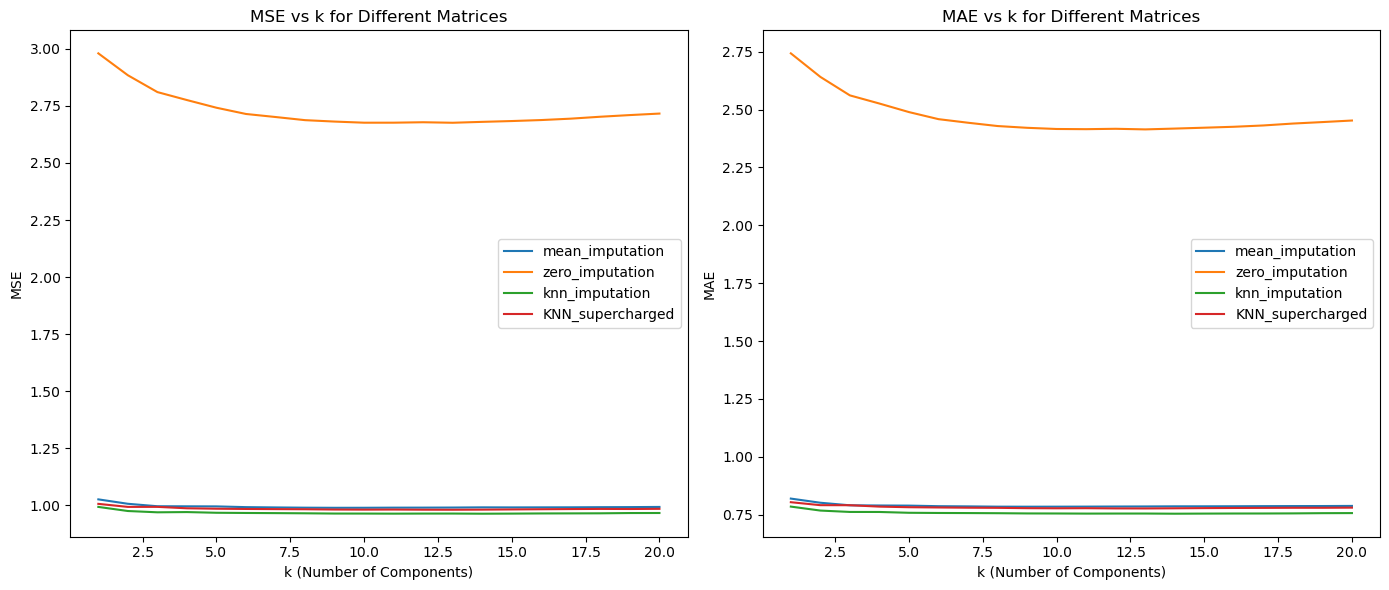

In [137]:
plot_best_model_performance(results)

We constat that we obtain the bests results by the KNN imputing method with about 12 singular values, the k number that we keep is pretty low which means that the latent factors are not numerous and that the majority of the information diversity can be picked up by only 12 components, also we constat the importance of the imputing as the filling of nan by 0 gives results much lower.

### 7 : Recommender system

In [56]:
final_matrix=predictionmatrix(user_item_train_KNN,12)


In [57]:
def recommend_movies(user_id, user_item_matrix, reconstructed_matrix, n=5):
    user_index = user_item_matrix.index.get_loc(user_id)
    predicted_ratings = reconstructed_matrix[user_index]
    user_ratings = user_item_matrix.loc[user_id]
    rated_items = user_ratings.dropna().index  
    all_items = user_item_matrix.columns  
    unrated_items = [item for item in all_items if item not in rated_items]
    predictions = pd.DataFrame({
        'ItemID': unrated_items,
        'PredictedRating': [predicted_ratings[user_item_matrix.columns.get_loc(item)] for item in unrated_items]
    })
    top_n_movies = predictions.sort_values(by='PredictedRating', ascending=False).head(n)['ItemID'].values
    print(f"Top {n} recommended movies for user {user_id}:", top_n_movies)
    return top_n_movies

In [58]:
recommend_movies(124,user_item_matrix,final_matrix)


Top 5 recommended movies for user 124: [1191 1450 1293 1599 1500]


array([1191, 1450, 1293, 1599, 1500], dtype=int64)